Running in Colab. Upload an image:


Saving carved_image (2).jpg to carved_image (2) (1).jpg
Using uploaded image: carved_image (2) (1).jpg
Enter 'v' for vertical carving or 'h' for horizontal carving: v
Enter reduction percentage (1-50): 30
Using direction: vertical, reduction: 30.0%
Removing 252 columns...
Processing seams 1-5 of 252...
Processing seams 6-10 of 252...
Processing seams 11-15 of 252...
Processing seams 16-20 of 252...
Processing seams 21-25 of 252...
Processing seams 26-30 of 252...
Processing seams 31-35 of 252...
Processing seams 36-40 of 252...
Processing seams 41-45 of 252...
Processing seams 46-50 of 252...
Processing seams 51-55 of 252...
Processing seams 56-60 of 252...
Processing seams 61-65 of 252...
Processing seams 66-70 of 252...
Processing seams 71-75 of 252...
Processing seams 76-80 of 252...
Processing seams 81-85 of 252...
Processing seams 86-90 of 252...
Processing seams 91-95 of 252...
Processing seams 96-100 of 252...
Processing seams 101-105 of 252...
Processing seams 106-110 of 252...

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Files are also available for download


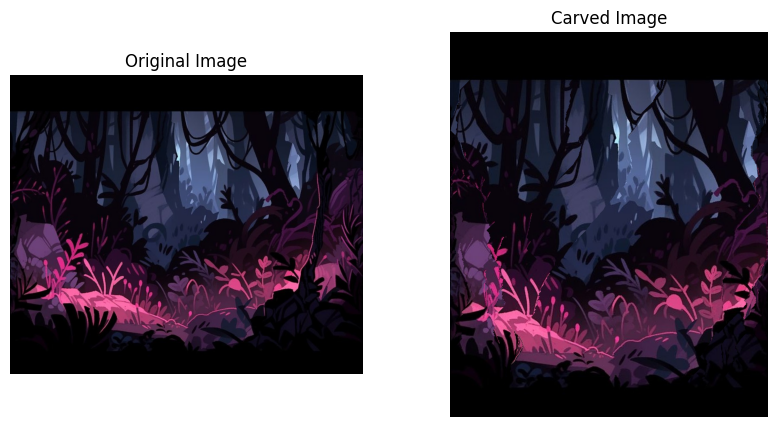

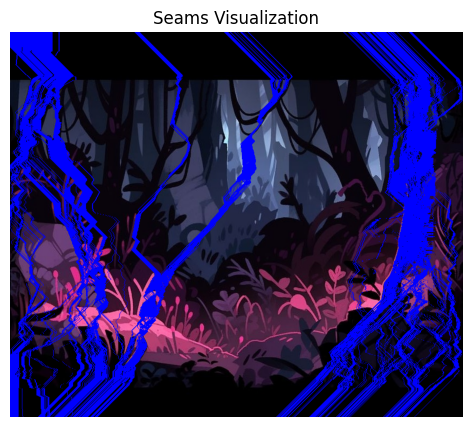

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from numba import jit, prange

@jit(nopython=True)
def calculate_energy_optimized(img):
    """
    Calculate energy using gradient magnitude as specified:
    e = |∂I/∂x| + |∂I/∂y|

    Optimized with Numba

    Args:
        img: Grayscale image

    Returns:
        energy: Energy map of the image
    """
    height, width = img.shape
    energy = np.zeros_like(img, dtype=np.float32)

    # Compute gradient using Sobel operator without manual loops
    for i in range(1, height-1):
        for j in range(1, width-1):
            # Sobel x kernel: [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
            gx = -img[i-1, j-1] - 2*img[i, j-1] - img[i+1, j-1] + \
                  img[i-1, j+1] + 2*img[i, j+1] + img[i+1, j+1]

            # Sobel y kernel: [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
            gy = -img[i-1, j-1] - 2*img[i-1, j] - img[i-1, j+1] + \
                  img[i+1, j-1] + 2*img[i+1, j] + img[i+1, j+1]

            energy[i, j] = abs(gx) + abs(gy)

    # Handle border pixels
    energy[0, :] = energy[1, :]
    energy[-1, :] = energy[-2, :]
    energy[:, 0] = energy[:, 1]
    energy[:, -1] = energy[:, -2]

    return energy

@jit(nopython=True)
def calculate_cumulative_energy_map_optimized(energy):
    """
    Calculate cumulative energy map for vertical seam calculation
    Optimized with Numba

    Args:
        energy: Energy map of the image

    Returns:
        cumulative_energy: Cumulative energy map
        backtrack: Matrix used for backtracking seams
    """
    height, width = energy.shape
    cumulative_energy = np.copy(energy)
    backtrack = np.zeros((height, width), dtype=np.int32)

    # Dynamic programming to fill the cumulative energy map
    for i in range(1, height):
        for j in range(width):
            if j == 0:
                if cumulative_energy[i-1, j] <= cumulative_energy[i-1, j+1]:
                    backtrack[i, j] = j
                    cumulative_energy[i, j] += cumulative_energy[i-1, j]
                else:
                    backtrack[i, j] = j+1
                    cumulative_energy[i, j] += cumulative_energy[i-1, j+1]
            elif j == width - 1:
                if cumulative_energy[i-1, j-1] <= cumulative_energy[i-1, j]:
                    backtrack[i, j] = j-1
                    cumulative_energy[i, j] += cumulative_energy[i-1, j-1]
                else:
                    backtrack[i, j] = j
                    cumulative_energy[i, j] += cumulative_energy[i-1, j]
            else:
                min_val = cumulative_energy[i-1, j-1]
                min_idx = j-1

                if cumulative_energy[i-1, j] < min_val:
                    min_val = cumulative_energy[i-1, j]
                    min_idx = j

                if cumulative_energy[i-1, j+1] < min_val:
                    min_val = cumulative_energy[i-1, j+1]
                    min_idx = j+1

                backtrack[i, j] = min_idx
                cumulative_energy[i, j] += min_val

    return cumulative_energy, backtrack

@jit(nopython=True)
def find_optimal_seam_optimized(cumulative_energy, backtrack):
    """
    Find optimal vertical seam based on cumulative energy
    Optimized with Numba

    Args:
        cumulative_energy: Cumulative energy map
        backtrack: Matrix used for backtracking seams

    Returns:
        seam: Array of x-coordinates of the seam for each y-coordinate
    """
    height, width = cumulative_energy.shape
    seam = np.zeros(height, dtype=np.int32)

    # Find the minimum value in the last row
    min_value = cumulative_energy[-1, 0]
    min_idx = 0

    for j in range(1, width):
        if cumulative_energy[-1, j] < min_value:
            min_value = cumulative_energy[-1, j]
            min_idx = j

    seam[-1] = min_idx

    # Backtrack to find the seam
    for i in range(height-2, -1, -1):
        seam[i] = backtrack[i+1, seam[i+1]]

    return seam

@jit(nopython=True)
def remove_seam_optimized(img, seam):
    """
    Remove a seam from the image
    Optimized with Numba

    Args:
        img: Image (grayscale only for Numba compatibility)
        seam: Vertical seam to remove

    Returns:
        new_img: Image with the seam removed
    """
    height, width = img.shape
    new_img = np.zeros((height, width-1), dtype=img.dtype)

    for i in range(height):
        # Copy pixels before the seam
        new_img[i, :seam[i]] = img[i, :seam[i]]
        # Copy pixels after the seam
        new_img[i, seam[i]:] = img[i, seam[i]+1:]

    return new_img

def remove_seam_color(img, seam):
    """
    Remove a seam from a color image

    Args:
        img: Color image
        seam: Vertical seam to remove

    Returns:
        new_img: Image with the seam removed
    """
    height, width, channels = img.shape
    new_img = np.zeros((height, width-1, channels), dtype=img.dtype)

    for i in range(height):
        for c in range(channels):
            # Use the optimized method channel by channel
            new_img[i, :, c] = remove_seam_optimized(img[i, :, c].reshape(1, width), np.array([seam[i]]))[0]

    return new_img

def visualize_seam(img, seam):
    """
    Visualize seam on the image

    Args:
        img: Original image
        seam: Vertical seam to visualize

    Returns:
        seam_img: Image with the seam marked in red
    """
    seam_img = np.copy(img)

    # If image is grayscale, convert it to color
    if len(seam_img.shape) == 2:
        seam_img = cv2.cvtColor(seam_img, cv2.COLOR_GRAY2RGB)

    height = seam_img.shape[0]

    # Mark the seam in red
    for i in range(height):
        seam_img[i, seam[i], 0] = 0    # Blue channel
        seam_img[i, seam[i], 1] = 0    # Green channel
        seam_img[i, seam[i], 2] = 255  # Red channel

    return seam_img

def carve_column_optimized(img):
    """
    Carve one column from the image
    Optimized version

    Args:
        img: Input image

    Returns:
        carved_img: Image with one column removed
        visualization: Image with the removed seam marked
    """
    # Convert to grayscale if it's a color image
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img.copy()

    # Calculate energy map
    energy = calculate_energy_optimized(gray)

    # Calculate cumulative energy map
    cumulative_energy, backtrack = calculate_cumulative_energy_map_optimized(energy)

    # Find optimal seam
    seam = find_optimal_seam_optimized(cumulative_energy, backtrack)

    # Create a visualization of the seam
    visualization = visualize_seam(img, seam)

    # Remove the seam
    if len(img.shape) == 3:
        carved_img = remove_seam_color(img, seam)
    else:
        carved_img = remove_seam_optimized(img, seam)

    return carved_img, visualization

def seam_carving_optimized(img, num_columns):
    """
    Perform seam carving to reduce the width of the image
    Optimized version

    Args:
        img: Input image
        num_columns: Number of columns to remove

    Returns:
        carved_img: Final resized image
        all_seams_img: Original image with all removed seams marked
    """
    start_time = time.time()

    # Initialize the output images
    current_img = img.copy()
    all_seams_img = img.copy()

    # If image is grayscale, convert it to color for visualization
    if len(all_seams_img.shape) == 2:
        all_seams_img = cv2.cvtColor(all_seams_img, cv2.COLOR_GRAY2RGB)

    # Store all seams for visualization
    height = img.shape[0]
    all_seams = np.zeros((height, num_columns), dtype=np.int32)

    # Pre-compile Numba functions with a dummy run
    if len(current_img.shape) == 3:
        gray = cv2.cvtColor(current_img, cv2.COLOR_RGB2GRAY)
    else:
        gray = current_img.copy()
    _ = calculate_energy_optimized(gray)

    # Batch processing - carve several seams at once for better performance
    batch_size = min(5, num_columns)  # Process up to 5 seams at once

    for batch_start in range(0, num_columns, batch_size):
        batch_end = min(batch_start + batch_size, num_columns)
        batch_count = batch_end - batch_start

        print(f"Processing seams {batch_start+1}-{batch_end} of {num_columns}...")

        for i in range(batch_start, batch_end):
            # Convert to grayscale if it's a color image
            if len(current_img.shape) == 3:
                gray = cv2.cvtColor(current_img, cv2.COLOR_RGB2GRAY)
            else:
                gray = current_img.copy()

            # Calculate energy map
            energy = calculate_energy_optimized(gray)

            # Calculate cumulative energy map
            cumulative_energy, backtrack = calculate_cumulative_energy_map_optimized(energy)

            # Find optimal seam
            seam = find_optimal_seam_optimized(cumulative_energy, backtrack)

            # Store the seam for visualization (adjusted for original image)
            for y in range(height):
                # Calculate the adjusted x-coordinate in the original image
                if i == 0:
                    all_seams[y, i] = seam[y]
                else:
                    # Adjust by how many pixels were already removed at this point
                    x_in_original = seam[y]
                    for j in range(i):
                        if all_seams[y, j] <= x_in_original + j:
                            x_in_original += 1
                    all_seams[y, i] = x_in_original

            # Remove the seam from the current image
            if len(current_img.shape) == 3:
                current_img = remove_seam_color(current_img, seam)
            else:
                current_img = remove_seam_optimized(current_img, seam)

    # Mark all seams on the original image
    for i in range(num_columns):
        for y in range(height):
            x = all_seams[y, i]
            if x < img.shape[1]:  # Make sure we don't go out of bounds
                all_seams_img[y, x, 0] = 0    # Blue channel
                all_seams_img[y, x, 1] = 0    # Green channel
                all_seams_img[y, x, 2] = 255  # Red channel

    end_time = time.time()
    print(f"Optimized seam carving completed in {end_time - start_time:.2f} seconds")

    return current_img, all_seams_img

def seam_carving_horizontal_optimized(img, num_rows):
    """
    Perform horizontal seam carving to reduce the height of the image
    Optimized version

    Args:
        img: Input image
        num_rows: Number of rows to remove

    Returns:
        carved_img: Final resized image
        all_seams_img: Original image with all removed seams marked
    """
    # Transpose image to reuse the vertical seam carving code
    transposed_img = np.transpose(img, (1, 0, 2)) if len(img.shape) == 3 else np.transpose(img)

    # Apply vertical seam carving on the transposed image
    carved_transposed, seams_visualization_transposed = seam_carving_optimized(transposed_img, num_rows)

    # Transpose back
    carved_img = np.transpose(carved_transposed, (1, 0, 2)) if len(carved_transposed.shape) == 3 else np.transpose(carved_transposed)
    seams_visualization = np.transpose(seams_visualization_transposed, (1, 0, 2))

    return carved_img, seams_visualization

def main_optimized(img_path=None, direction=None, reduction_percent=None, output_dir=None):
    """
    Main function to demonstrate optimized seam carving

    Args:
        img_path: Path to the input image (if None, will prompt)
        direction: 'v' for vertical carving, 'h' for horizontal (if None, will prompt)
        reduction_percent: Percentage of width/height to remove (if None, will prompt)
        output_dir: Directory to save output images (if None, will use current directory)
    """
    # For Google Colab: If no image path provided, offer to upload
    if img_path is None:
        try:
            from google.colab import files
            print("Running in Colab. Upload an image:")
            uploaded = files.upload()
            img_path = list(uploaded.keys())[0]
            print(f"Using uploaded image: {img_path}")
        except ImportError:
            # Not in Colab, use regular input
            img_path = input("Enter the path to the input image: ")

    # Load the image
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Could not read the image at {img_path}.")
        return

    # Convert BGR to RGB for visualization
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    # Ask for carving direction if not provided
    if direction is None or direction not in ['v', 'h']:
        direction = input("Enter 'v' for vertical carving or 'h' for horizontal carving: ").lower()

    # Ask for reduction percentage if not provided
    if reduction_percent is None:
        reduction_percent = float(input("Enter reduction percentage (1-50): "))
    print(f"Using direction: {'vertical' if direction == 'v' else 'horizontal'}, reduction: {reduction_percent}%")

    if direction == 'v':
        # Calculate number of columns to remove
        num_columns = int(img.shape[1] * reduction_percent / 100)
        print(f"Removing {num_columns} columns...")

        # Perform vertical seam carving with optimized version
        carved_img, seams_visualization = seam_carving_optimized(img_rgb, num_columns)
    else:
        # Calculate number of rows to remove
        num_rows = int(img.shape[0] * reduction_percent / 100)
        print(f"Removing {num_rows} rows...")

        # Perform horizontal seam carving with optimized version
        carved_img, seams_visualization = seam_carving_horizontal_optimized(img_rgb, num_rows)

    # Display results
    plt.subplot(1, 2, 2)
    plt.imshow(carved_img)
    plt.title('Carved Image')
    plt.axis('off')

    plt.figure(figsize=(10, 5))
    plt.imshow(seams_visualization)
    plt.title('Seams Visualization')
    plt.axis('off')

    # Set output directory
    if output_dir is None:
        try:
            from google.colab import files
            output_dir = "."  # Use current directory in Colab
        except ImportError:
            output_dir = input("Enter directory to save output images (press Enter for current directory): ") or "."

    # Save carved image
    carved_output_path = f"{output_dir}/carved_image.jpg"
    cv2.imwrite(carved_output_path, cv2.cvtColor(carved_img, cv2.COLOR_RGB2BGR))

    # Save seams visualization
    seams_output_path = f"{output_dir}/seams_visualization.jpg"
    cv2.imwrite(seams_output_path, cv2.cvtColor(seams_visualization, cv2.COLOR_RGB2BGR))

    print(f"Output images saved to {output_dir}")

    # For Colab: offer to download the results
    try:
        from google.colab import files
        files.download(carved_output_path)
        files.download(seams_output_path)
        print("Files are also available for download")
    except ImportError:
        pass

    plt.show()

def compare_performance(img_path=None, direction='v', reduction_percent=20):
    """
    Compare performance between original and optimized implementations

    Args:
        img_path: Path to the input image
        direction: 'v' for vertical carving, 'h' for horizontal
        reduction_percent: Percentage of width/height to remove
    """
    # Load the image
    if img_path is None:
        try:
            from google.colab import files
            print("Running in Colab. Upload an image for performance comparison:")
            uploaded = files.upload()
            img_path = list(uploaded.keys())[0]
        except ImportError:
            img_path = input("Enter the path to the input image for performance comparison: ")

    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Could not read the image at {img_path}.")
        return

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Calculate number of columns/rows to remove
    if direction == 'v':
        num_to_remove = int(img.shape[1] * reduction_percent / 100)
        print(f"Testing with {reduction_percent}% vertical reduction ({num_to_remove} columns)")
    else:
        num_to_remove = int(img.shape[0] * reduction_percent / 100)
        print(f"Testing with {reduction_percent}% horizontal reduction ({num_to_remove} rows)")

    # Test original implementation
    print("\nRunning original implementation...")
    start_time = time.time()

    if direction == 'v':
        original_carved, _ = seam_carving(img_rgb.copy(), num_to_remove)
    else:
        original_carved, _ = seam_carving_horizontal(img_rgb.copy(), num_to_remove)

    original_time = time.time() - start_time
    print(f"Original implementation completed in {original_time:.2f} seconds")

    # Test optimized implementation
    print("\nRunning optimized implementation...")
    start_time = time.time()

    if direction == 'v':
        optimized_carved, _ = seam_carving_optimized(img_rgb.copy(), num_to_remove)
    else:
        optimized_carved, _ = seam_carving_horizontal_optimized(img_rgb.copy(), num_to_remove)

    optimized_time = time.time() - start_time
    print(f"Optimized implementation completed in {optimized_time:.2f} seconds")

    # Calculate and display speedup
    speedup = original_time / optimized_time
    print(f"\nSpeedup: {speedup:.2f}x faster")

    # Display results side by side
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(original_carved)
    plt.title(f'Original Algorithm\n({original_time:.2f}s)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(optimized_carved)
    plt.title(f'Optimized Algorithm\n({optimized_time:.2f}s)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Uncomment one of these options:

    # Option 1: Run the optimized version directly
    main_optimized()

    # Option 2: Compare performance between original and optimized
    # compare_performance()